<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/notebooks/06-Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Autoencoders</h1>

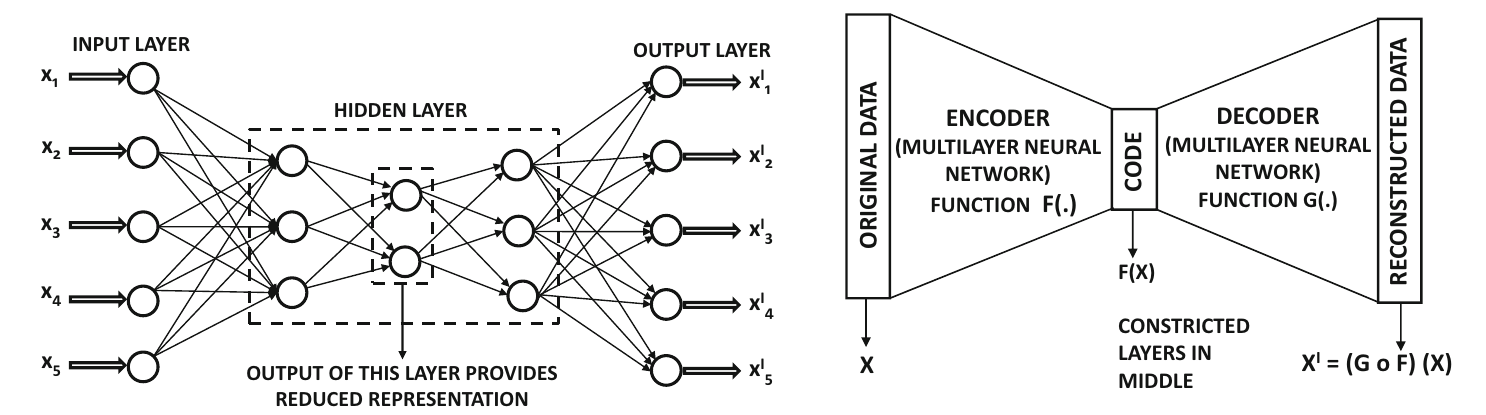


En esta notebook mostraremos varios usos de los autoencoders. En particular mostraremos su uso en tareas de

* *Denoising*
* Detección de anomalías
* Reducción de dimensionalidad

De manera paralela, mostraremos varias formas de definir su arquitectura, dependiendo de si queremos acceder individualmente al *encoder* y *decoder*.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ejemplo 1: Demostración básica con una MLP

En este ejemplo mostramos un autoencoder muy sencillo basado en una MLP, con este módelo ilustraremos las diferentes partes del proceso: la codificación y la decodificación.

Para esto, usaremos el dataset MNIST de Keras. Entrenaremos un autoencoder para reconstruir la imágen de cada dígito.

Ahora, usaremos el modelo `Model` de Keras, en lugar de `Sequential`.

In [ ]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()  # Observa que no necesitamos las etiquetas

#--- Preprocesamiento ---
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],-1))
x_test = x_test.reshape((x_test.shape[0],-1))
print(x_train.shape)
print(x_test.shape)

Usaremos la clase `Model` para construir el autoencoder. La diferencia con la clase `Sequence` es que, con esta clase, tenemos que especificar cómo son las conexiones entre capas.

* Por un lado, crearemos la red *completa*, la cual entrenaremos con el conjunto de datos.
* Por otro lado, recuperaremos las redes *entrada-oculta* y *oculta-salida* para visualizar la reducción y la reconstrucción.

El modelo completo

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

encoding_dim = 16

input_layer = Input(shape=(784,))  # Otra manera de crear la capa de entrada
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(784, activation='sigmoid')(encoded)  # ¿POR QUÉ LA ACTIVACIÓN SIGMOIDE?

autoencoder = Model(input_layer, decoded)

🔽 Podríamos definir la arquitectura del modelo de forma más *tradicional* usando la clase `Sequential`

In [ ]:
# from keras import Input, Sequential
# from keras.layers import Dense

# encoding_dim = 16

# model = Sequential()
# model.add(Input(shape=(784,)))
# model.add(Dense(encoding_dim, activation='relu'))
# model.add(Dense(784, activation='sigmoid'))

In [ ]:
# from keras import Sequential
# from keras.layers import Dense

# encoding_dim = 16

# model = Sequential()
# model.add(Dense(encoding_dim, activation='relu',input_dim=784))
# model.add(Dense(784, activation='sigmoid'))

Compilamos el modelo. Observa que, tecnicamente, es una tarea de regresión, por lo cual usamos la pérdida `MSE`.

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

Definimos el encoder y decoder por separado. Estos modelos no serán entrenados directamente, por lo tanto, no necesitan ser compilados.

In [ ]:
# ------ El encoder ------
encoder = Model(input_layer, encoded)

# ------ El decoder ------
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1](encoded_input) # la última capa del modelo 'completo' autoencoder

decoder = Model(encoded_input, decoder_layer)

Agreagamos un `EarlyStopping`

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=2)

Entrenamos el modelo, observa que el conjunto $X$, $y$ está formado por el mismo conjunto de imágenes. De igual manera, los datos de validación.

In [ ]:
history = autoencoder.fit(x_train, x_train,
                epochs = 20,
                batch_size = 256,
                validation_split = 0.15,
                callbacks = [es])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5),dpi=100)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
autoencoder.evaluate(x_test,x_test)

Los modelos `encoder` y `autoencoder` ya están entrenados ahora. Podemos usarlos *por separado*

In [ ]:
# ------ Codificamos las imágenes ------
encoded_img = encoder.predict(x_test)
# ------ Decodificamos las imágenes codificada ------
decoded_img = decoder.predict(encoded_img)

Ahora, mostramos 5 imágenes aleatorias del conjunto de prueba. En cada una de ellas, mostramos la imágen original, la *imágen* codificada y la imágen reconstruida.

In [ ]:
# ------ Escogemos 5 imágenes aleatorias ------
m = x_test.shape[0]
idxs = np.random.choice(m,size=5,replace=False)

plt.figure(figsize=(20, 12))
for i,idx in enumerate(idxs):
    # Mostrar original
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Mostrar codificación latente
    ax = plt.subplot(3, 5, i + 1 + 5)
    plt.imshow(encoded_img[idx].reshape(encoding_dim, 1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Mostrar reconstrucción
    ax = plt.subplot(3, 5, i + 1 + 10)
    plt.imshow(decoded_img[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Es importante notar que la codificación latente no es una versión comprimida de la imágen:

In [ ]:
import math

if math.modf(math.sqrt(encoding_dim))[0]==0:
    # ------ Escogemos 5 imágenes aleatorias ------
    m = x_test.shape[0]
    idxs = np.random.choice(m,size=5,replace=False)
    sqrt_enc_dim = int(math.sqrt(encoding_dim))
    plt.figure(figsize=(20, 12))
    for i,idx in enumerate(idxs):
        # Mostrar original
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(x_test[idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # Mostrar codificación latente
        ax = plt.subplot(3, 5, i + 1 + 5)
        plt.imshow(encoded_img[idx].reshape(sqrt_enc_dim, sqrt_enc_dim))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # Mostrar reconstrucción
        ax = plt.subplot(3, 5, i + 1 + 10)
        plt.imshow(decoded_img[idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
else:
    print("La dimensión de la codificación no es un cuadrado")

##⭕ Práctica

1. ¿Qué pasa si movemos el parámetro del número de neuronas en la capa oculta? ¿Qué pasa con las reconstrucciones?
2. Crea un modelo más profundo.

## Denoising

Usaremos este mismo modelo entrenado para quitar el ruido de un imágen (denoising). Tomaremos imágenes de prueba y les añadiremos ruido, se las pasaremos a la red para que haga las predicciones.

In [ ]:
noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
pred = autoencoder.predict(x_test_noisy)

Mostremos algunas imágenes aleatorias. En cada caso, mostramos la imagen con ruido y la imagen con *denoising*.

In [ ]:
m = x_test_noisy.shape[0]
idxs = np.random.choice(m,size=5,replace=False)

plt.figure(figsize=(20, 4))
for i,idx in enumerate(idxs):
    # Mostrar original con ruido
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Mostrar reconstrucción
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Ejemplo 2: Demostración básica con un Autoencoder Convolucional

Leemos el conjunto de datos otra vez

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))

Este modelo está basado en una CNN, por lo tanto ahora no nos interesará analizar las partes del encoder y decoder. Observa las capas de `UpSampling2D` ([documentación](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D)), estas capas aumentan el tamaño de la imágen repitiendo los valores de pixeles. En este caso, el factor de aumento es 2. Es simétrico respecto al `MaxPooling2D` con factor 2.

Por otro lado, observa que la capa de salida es una capa convolucional de un sólo filtro. Por ser la salida y como nuestros valores de pixeles están re-escalados al intervalo $[0,1]$, tenemos una activación sigmoide.

Finalmente, siempre usamos `padding='same'` para no modificar el tamaño de las imágenes con los filtros de convolución.

In [ ]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Sequential

model = Sequential()
# ------ encoder ------
model.add(Conv2D(30, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
# ------ decoder ------
model.add(Conv2D(15, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(30, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # <--- capa de salida

model.compile(optimizer= 'adam', loss = 'binary_crossentropy')
model.summary()

Entrenamos el modelo

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
history = model.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                validation_data=(x_test, x_test),
                callbacks = [es])

Curvas de entrenamiento

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5),dpi=100)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Realizamos las predicciones

In [ ]:
pred = model.predict(x_test)

Algunos ejemplos mostrando la imágen original y la imagen reconstruida. Ahora no podemos mostrar la codificación latente porque no tenemos el encoder por separado.

In [ ]:
# ------ Escogemos 5 imágenes aleatorias ------
m = x_test.shape[0]
num_images = 4
idxs = np.random.choice(m,size=num_images,replace=False)

plt.figure(figsize=(num_images*4, num_images*2))
for i,idx in enumerate(idxs):
    # Mostrar original
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Mostrar reconstrucción
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(pred[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising pt. 1

En esta parte, repetimos la estrategia pasada para usar el autoencoder como herramienta de *denoising*. Es decir, usamos el modelo entrenado con las imágenes originales y hacemos las predicciones para las imágenes con ruido.

In [ ]:
x_test_noisy = np.reshape(x_test_noisy,(-1,28,28,1))

In [ ]:
pred = model.predict(x_test_noisy)

In [ ]:
m = x_test_noisy.shape[0]
idxs = np.random.choice(m,size=5,replace=False)

plt.figure(figsize=(20, 4))
for i,idx in enumerate(idxs):
    # Mostrar original con ruido
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Mostrar reconstrucción
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Podemos notar una mejoría. Ahora usaremos una mejor estrategia.

## Denoising pt. 2

Entrenaremos usando las imágenes con ruido y buscaremos que reconstruya las imágenes originales.

In [ ]:
noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
model = Sequential()
# ------ encoder ------
model.add(Conv2D(35, 3, activation= 'relu', padding='same', input_shape = (28,28,1)))
model.add(MaxPooling2D(2, padding= 'same'))
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
# ------ decoder ------
model.add(Conv2D(25, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(35, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(1,3,activation='sigmoid', padding= 'same')) # output layer

model.summary()

model.compile(optimizer= 'adam', loss = 'binary_crossentropy')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=2)

Entrenamos el modelo

In [ ]:
history = model.fit(x_train_noisy, x_train,
                epochs=15,
                batch_size=128,
                validation_data=(x_test_noisy, x_test),
                callbacks = [es])

Curvas de entrenamiento

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5),dpi=100)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Realizamos las predicciones

In [ ]:
pred = model.predict(x_test_noisy)

Veamos algunos ejemplos. Como se puede ver, ahora que la red ha sido entrenada con este propósito, se observan mejores resultados.

In [ ]:
m = x_test_noisy.shape[0]
idxs = np.random.choice(m,size=5,replace=False)

plt.figure(figsize=(20, 4))
for i,idx in enumerate(idxs):
    # Mostrar original con ruido
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Mostrar reconstrucción
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Ejemplo 3: Anomaly Detection


Un electrocardiograma (ECG) es una prueba sencilla que permite comprobar el ritmo y la actividad eléctrica del corazón. El electrocardiograma registra las señales eléctricas del corazón y se usa para detectar con rapidez problemas cardíacos y controlar la salud del corazón.

El conjunto de datos original de "ECG5000" es un ECG de 20 horas de duración. A continuación, se seleccionaron aleatoriamente 5,000 latidos, cada uno con el mismo número de datos. El paciente tiene una insuficiencia cardíaca congestiva grave y los valores de clase se obtuvieron mediante una anotación automática.

**No usaremos los valores de clase para el entrenamiento**.

[Fuente del dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)

## Lectura de los datos y preprocesamiento

In [ ]:
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/04%20Deep%20Learning/data/ecg.csv"
df = pd.read_csv(url, sep=',',index_col=0)
df

Dividimos en entrenamiento y prueba. Observa que no usaremos, por ahora, las etiquetas

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, _, _ = train_test_split(df.values, df.values[:,0:1], test_size=0.2, random_state=111)

Re-escalamos al intervalo [0,1]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)
train_data_scaled = data_scaled.transform(x_train)
test_data_scaled = data_scaled.transform(x_test)

Separamos los datos en normales y anómalos.

In [ ]:
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomalous_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomalous_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

Creamos un conjunto de datos de prueba juntando los arreglos previos.

In [ ]:
test_data = np.vstack((normal_test_data, anomalous_test_data))
test_data.shape

## Visualización

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.suptitle("Comparación entre un ECG Normal y Anómalo",fontsize=16)
plt.subplot(2, 2, 1)
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("ECG Normal")
plt.subplot(2, 2, 2)
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0],color='red')
plt.title("ECG Anomalo")
plt.subplot(2, 2, 3)
plt.grid()
plt.plot(np.arange(140), normal_train_data[1])
plt.title("ECG Normal")
plt.subplot(2, 2, 4)
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[1],color='red')
plt.title("ECG Anomalo")
plt.show()

Defnimos el modelo. Observa la capa de salida.

En este caso no nos interesa tener el enconder y decoder por separado por lo que podemos usar un modelo `Sequential`

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Dense(32, activation="relu",input_shape=(140,)))
model.add(Dense(16, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(140, activation="sigmoid"))

model.compile(optimizer='adam', loss='mae')

Entrenamos el modelo. Observa las diferentes elecciones de datos de validación, son equivalentes en cuanto al resultado pero no en cuanto a las curvas de entrenamiento.

In [ ]:
history = model.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
        #   validation_data = (normal_test_data,normal_test_data),
          shuffle=True)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xticks(history.epoch)
plt.legend()
plt.show()

Clasificaremos un ECG como anómalo si el error de reconstrucción es superior a una desviación estándar respecto a los ejemplos de entrenamiento normales. En primer lugar, vamos a trazar un ECG normal del conjunto de entrenamiento, la reconstrucción después de ser codificado y decodificado por el autoencoder, y el error de reconstrucción.

Realizamos las predicciones, tanto con los datos *normales* como con los datos *anómalos*.

In [ ]:
predictions_normal = model.predict(normal_test_data)
predictions_anom = model.predict(anomalous_test_data)

Calculamos las perdidas en cada uno de los dos casos. Esta función `mae` nos regresa el arreglo de todas las perdidas individuales.

In [ ]:
from tensorflow.keras.losses import mae

test_loss_normal = mae(predictions_normal, normal_test_data).numpy()
test_loss_anom = mae(predictions_anom, anomalous_test_data).numpy()

Visualicemos las distribuciones de los costos en las reconstrucciones de ambas clases.

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 4),dpi=100)
ax = plt.subplot(1, 2, 1)
ax.title.set_text("Test Loss in Normal ECG")
sns.histplot(test_loss_normal, ax=ax)
plt.axvline(x=np.mean(test_loss_normal),c='red')
plt.xlabel("Loss")
plt.ylabel("No of examples")
ax = plt.subplot(1, 2, 2)
ax.title.set_text("Test Loss in Anomalous ECG")
sns.histplot(test_loss_anom, ax=ax)
plt.axvline(x=np.mean(test_loss_anom),c='red')
plt.xlabel("Loss")
plt.ylabel("No of examples")
plt.show()

Ejemplo con un ECG Normal

In [ ]:
plt.figure(dpi=100)
plt.suptitle("Loss: {:.3f}".format(test_loss_normal[0]))
plt.plot(normal_test_data[0], c='b')
plt.plot(predictions_normal[0], c='r')
plt.fill_between(np.arange(140), predictions_normal[0], normal_test_data[0], color='gray')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Ejemplo con un ECG anómalo, podemos ver que el error (perdida) es mayor en esta predicción.

In [ ]:
plt.figure(dpi=100)
plt.suptitle("Loss: {:.3f}".format(test_loss_anom[0]))
plt.plot(anomalous_test_data[0], c='b')
plt.plot(predictions_anom[0], c='r')
plt.fill_between(np.arange(140), predictions_anom[0], anomalous_test_data[0], color='gray')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Exploremos ahora la pérdida en el conjunto de entrenamiento. Definiremos un umbral $p$, una desviación standard arriba del promedio. Este valor fue considerado arbitrariamente.

In [ ]:
from tensorflow.keras.losses import mae

# ----- Calculamos las pérdidas de entrenamiento -----
train_predictions = model.predict(normal_train_data)
train_loss = mae(train_predictions, normal_train_data).numpy()

# ----- Calculamos el umbral -----
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: {:.3f}".format(threshold))

# ----- Graficamos -----
plt.figure(figsize=(9,5))
plt.suptitle("Train Loss in Normal ECG")
sns.histplot(train_loss)
plt.axvline(x=np.mean(train_loss),c='red', label='Mean')
plt.axvline(x=threshold,c='black', label='Threshold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.legend(loc='best')
plt.show()

Ahora, definiremos una función para predecir la clase de cada ECG. La función está dada por

\begin{align}
        f(x) = \left\{
        \begin{array}{cl}
        1 & x \leq \text{threshold} \\
        0 & x > \text{threshold}.
        \end{array}
        \right.
    \end{align}

In [ ]:
from tensorflow.keras.losses import mae
from tensorflow.math import less

def predict_label(model, data, threshold):
    '''
    Esta función predice la etiqueta de los datos a partir del umbrar que definimos
    '''
    predictions = model(data)
    loss = mae(predictions, data)
    return less(loss, threshold)

In [ ]:
y_test = np.array([1 for x in normal_test_data]+[0 for x in anomalous_test_data])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

predicted_labels = predict_label(model=model,
                                 data=test_data,
                                 threshold=threshold)

print("Accuracy = {:.3f}".format(accuracy_score(y_test, predicted_labels)))
print("Precision = {:.3f}".format(precision_score(y_test, predicted_labels)))
print("Recall = {:.3f}".format(recall_score(y_test, predicted_labels)))
print(f"Confusion Matrix:\n{confusion_matrix(y_test, predicted_labels)}")

✨ Algunas observaciones:

* Dado que no nos interesa predecir (reconstruir) los ECG originales, no hubo necesidad de re-escalar a la escala original de los datos.
* El objetivo de este autoencoder es detectar anomalías en los ECG.

## ⭕ Práctica

Prueba arquitecturas más profundas para este ejercicio, ¿puedes subir el rendimiento de la tarea de clasificación?

# Ejemplo 4: Dimensionality Reduction

En este ejemplo mostraremos cómo usar los autoencoders como herramientas de reducción de dimensionalidad.

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# ----- Cargamos el conjunto de datos MNIST -----
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# ----- Normalizamos los valores de pixeles al intervalo [0,1] -----
x_train = x_train/255.
x_test = x_test/255.

# ----- Como siempre, mostramos algunos ejemplos -----
idxs = np.random.choice(range(x_train.shape[0]), size=10, replace=False)
plt.figure(figsize=(15,4))
for i,idx in enumerate(idxs):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(x_train[idx].reshape(28,28),cmap='RdBu');
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Reshape
from tensorflow.keras.models import Sequential, Model

# ----- Dimensión Latente del Espacio de Codificación -----
latent_dim = 2

img_shape = (x_train.shape[1], x_train.shape[2])

encoder = Sequential([
    Flatten(input_shape=img_shape),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(latent_dim, name='encoder_output',activation='sigmoid')
])

decoder = Sequential([
    Dense(16, activation='relu', input_shape=(latent_dim,)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(img_shape[0] * img_shape[1], activation='relu'),
    Reshape(img_shape)
])

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))

autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

## ➖ Definir un callback propio

A continuación se muestra cómo definir un callback propio. Este callback grafica la representación latente 2-dimensional en cada época.

* Guía para hacer callbacks propios: https://keras.io/guides/writing_your_own_callbacks/
* Código de la clase general `tensorflow.keras.callbacks.Callback`: https://github.com/keras-team/keras/blob/v2.9.0/keras/callbacks.py#L576

In [ ]:
import tensorflow
import numpy as np

class SaveEncodings(tensorflow.keras.callbacks.Callback):
    def __init__(self, x_test, y_test,fname):
        super(SaveEncodings, self).__init__()
        self.x_test = x_test
        self.y_test = y_test
        self.fname = fname
        self.tensor = []
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs={}):
        self.current_epoch = self.current_epoch + 1
        encoder_model = Model(inputs=self.model.input,
                              outputs=self.model.get_layer('encoder_output').output)
        encoder_output = encoder_model(self.x_test)
        self.tensor.append(encoder_output)

    def on_train_end(self, logs=None):
        """Called at the end of training.
        Subclasses should override for any actions to run.
        Args:
            logs: Dict. Currently the output of the last call to `on_epoch_end()`
            is passed to this argument for this method but that may change in
            the future.
        """
        X = np.array(self.tensor)
        np.save(self.fname,X)

Definimos (inicializamos) nuestro *callback*.

In [ ]:
pe = SaveEncodings(x_test[:500],y_test[:500],"tensor.npy")

## Continuamos con el entrenamiento

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2, mode='min')

In [ ]:
callbacks = [es,pe]  # Usando nuestro callback
# callbacks = [es]

In [ ]:
history = autoencoder.fit(x_train, x_train,
                          epochs=15, batch_size=32,
                          verbose=2, callbacks=callbacks,
                          validation_split=0.1)

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# ----- Aplicamos PCA -----
pca = PCA(n_components=2)
x_reshaped = x_test[0:500].reshape(-1, 784)
x_transformed = pca.fit_transform(x_reshaped)

# ----- Obtenemos la representación reducida de la red -----
x_dimred = encoder.predict(x_test[0:500])

In [ ]:
plt.figure(figsize=(12, 4))
plt.suptitle("Comparación entre PCA y AE",fontsize=16)
plt.subplot(1, 2, 1)
plt.suptitle("PCA")
plt.scatter(x_transformed[:, 0], x_transformed[:, 1],
            s=20, alpha=.8, cmap='Set1', c=y_test[0:500])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.subplot(1, 2, 2)
plt.suptitle("Autoencoder")
plt.scatter(x_dimred[:, 0], x_dimred[:, 1],
            s=20, alpha=.8, cmap='Set1', c=y_test[0:500])
plt.xlabel('Latent Component 1')
plt.ylabel('Latent Component 2')
plt.show()

## Evolución de las representaciones

Ahora, exploremos la evolución de las representaciones latentes. Primero, carguemos el tensor de numpy que las contiene, este fue generado por nuestro callback. Debe tener la forma:

$$\text{Número de épocas}\times\text{Ejemplos}\times 2$$

In [ ]:
representaciones = np.load("tensor.npy")
representaciones.shape

Graficamos las representaciones 2-dimensionales a lo largo del entrenamiento.

In [ ]:
import matplotlib.pyplot as plt
from itertools import product

rows = 4
cols = 3

fig, axs = plt.subplots(rows,cols, dpi=100, figsize=(4*rows+2,3*cols+2))

for j,(r,c) in enumerate(product(range(rows),range(cols))):
    if j<representaciones.shape[0]:
        axs[r,c].scatter(representaciones[j,:,0], representaciones[j,:,1],c=y_test[0:500],
                        s=20, alpha=0.75, cmap='Set1')
        axs[r,c].set_title(f'Epoch {j+1}')
    else: # Cuando salgamos del rango, dejar en blanco
        axs[r,c].get_xaxis().set_visible(False)
        axs[r,c].get_yaxis().set_visible(False)
        axs[r,c].axis('off')
fig.tight_layout()
fig.show()

##⭕ Práctica

Modifica la arquitectura de la red y los parámetros de entrenamiento para lograr una mejor separación de las clases.

## ➖ Generemos una animación con estas imágenes

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
import pylab as pl

num_frames = representaciones.shape[0]

def animate(i):
    axes.clear()
    c = axes.scatter(representaciones[i,:,0], representaciones[i,:,1],c=y_test[0:500],
                        s=20, alpha=0.75, cmap='Set1')
    return c

fig, axes = pl.subplots(1, 1)
anim = animation.FuncAnimation(fig, animate, frames=num_frames)
anim.save('animation.mp4', fps=1, dpi=600)
fig.show()

## ¿Por qué usar autoencoders teniendo PCA, t-SNE, etc..?

* Las redes neuronales permiten una mayor potencia y flexibilidad en la reducción de datos no lineales al variando el número y el tipo de capas utilizadas en las etapas intermedias. Además, eligiendo tipos específicos de funciones de activación en determinadas capas, se puede diseñar la naturaleza de la reducción a las propiedades de los datos.

* Muchos métodos de reducción de dimensionalidad tienen dificultades para tratar con datos no vistos durante el entrenamiento. Por otro lado, es relativamente sencillo asignar puntos pasándolos por la red. Por ejemplo, `t-SNE` no tiene manera de transformar datos no vistos durante el entrenamiento.
